In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [2]:
!nvidia-smi

Mon Aug 31 20:09:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Импорт библиотек

In [3]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import os

import torch.nn as nn
import torch.nn.functional as F

# Загрузка данных

Я выбрал два класса Carambola и Muskmelon, которые наиболее сбалансированны (50 на 50)

Попробую решить задачу классификации обычной полносвязной сетью.

Данные https://www.kaggle.com/chrisfilo/fruit-recognition

In [4]:
# проверим наличие данных

path = '/content/drive/My Drive/Colab Notebooks/mmad_mipt/hw1_b3/data'
print(os.listdir(path))

['Carambola', 'Muskmelon']


In [5]:
# преобразуем данные в тензоры одного размера

data_size = (248, 248)
composed = torchvision.transforms.Compose([torchvision.transforms.Resize(data_size), torchvision.transforms.ToTensor()])

# данные

df = torchvision.datasets.ImageFolder(path, composed)

In [6]:
# кол-во данных

len(df)

4158

In [7]:
df.classes

['Carambola', 'Muskmelon']

In [8]:
# отобразим один элемент данных

df[0]

(tensor([[[0.1804, 0.1608, 0.1686,  ..., 0.0118, 0.0118, 0.0118],
          [0.1804, 0.1608, 0.1569,  ..., 0.0118, 0.0157, 0.0196],
          [0.1647, 0.1765, 0.1569,  ..., 0.0157, 0.0196, 0.0196],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6980, 0.6863, 0.6863],
          [0.0000, 0.0000, 0.0000,  ..., 0.6980, 0.6902, 0.6863],
          [0.0000, 0.0000, 0.0000,  ..., 0.6941, 0.6941, 0.6863]],
 
         [[0.1804, 0.1765, 0.1765,  ..., 0.0471, 0.0471, 0.0471],
          [0.1804, 0.1765, 0.1725,  ..., 0.0471, 0.0510, 0.0510],
          [0.1608, 0.1804, 0.1725,  ..., 0.0471, 0.0510, 0.0510],
          ...,
          [0.0196, 0.0196, 0.0196,  ..., 0.6980, 0.6863, 0.6863],
          [0.0196, 0.0196, 0.0235,  ..., 0.6980, 0.6902, 0.6863],
          [0.0196, 0.0235, 0.0235,  ..., 0.6941, 0.6941, 0.6863]],
 
         [[0.1451, 0.1059, 0.1333,  ..., 0.0000, 0.0000, 0.0000],
          [0.1451, 0.1098, 0.1020,  ..., 0.0000, 0.0039, 0.0039],
          [0.1373, 0.1373, 0.1020,  ...,

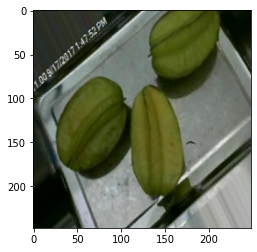

In [9]:
plt.imshow(df[0][0].permute(1, 2, 0))

In [10]:
# сделаем train-test split

train, test = torch.utils.data.random_split(df, [int(len(df) * 0.8), len(df) - int(len(df) * 0.8)])

len(train), len(test)

(3326, 832)

In [11]:
# разделим по батчам

train = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)

# SimpleNN
Архитектура : входной слой, 2 скрытых слоя, выходной слой

Функции активации слоёв relu

In [12]:
class SimpleNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(3*248*248, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output_layer(x)
        return x

In [13]:
# переходим на gpu

device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [14]:
model = SimpleNN().to(device)
print(model)

SimpleNN(
  (input_layer): Linear(in_features=184512, out_features=128, bias=True)
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=2, bias=True)
)


In [15]:
# функция потерь и оптимизатор

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

После 5 эпохи модель начла переобучаться

In [16]:
%%time

train_losses = []
valid_losses = []

for epoch in range(5):

    train_loss = 0.0
    valid_loss = 0.0

    # тренировка модели

    for X, y in train:

        # перенесём данные на gpu
        X, y = X.to(device), y.to(device)

        # обнуление градиентов
        model.zero_grad()

        # прямой проход
        out = model(X)

        # batch-loss
        loss = criterion(out, y)
        
        # обратный проход
        loss.backward()

        # оптимизируем
        optimizer.step()

        # обновялем training-loss
        train_loss += loss.item() * X.size(0)

    # валидация 
    
    for X, y in test:
        
        # перенесём данные на gpu
        X, y = X.to(device), y.to(device)
        
        # прямой проход
        out = model(X)
        
        # batch-loss
        loss = criterion(out, y)
        
        # обновляем validation-loss 
        valid_loss += loss.item() * X.size(0)
    
    # считаем средние потери
    train_loss = train_loss/len(train.sampler)
    valid_loss = valid_loss/len(test.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # статистика по эпохам
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    



Epoch: 0 	Training Loss: 0.648106 	Validation Loss: 0.117557
Epoch: 1 	Training Loss: 0.099531 	Validation Loss: 0.060492
Epoch: 2 	Training Loss: 0.094746 	Validation Loss: 0.211891
Epoch: 3 	Training Loss: 0.064233 	Validation Loss: 0.075645
Epoch: 4 	Training Loss: 0.063738 	Validation Loss: 0.044923
CPU times: user 2min 20s, sys: 11.8 s, total: 2min 32s
Wall time: 2min 55s


In [17]:
# посмотрим accuracy на тесте 

with torch.no_grad():
    correct = 0
    total = 0

    for X, y in test:

        # перенесём данные на gpu
        X = X.to(device)
        y = y.to(device)

        # прямой проход
        outputs = model(X)

        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))



Test Accuracy of the model: 98.4375 %


In [18]:
# сохраним модель

torch.save(model.state_dict(), 'model.ckpt')

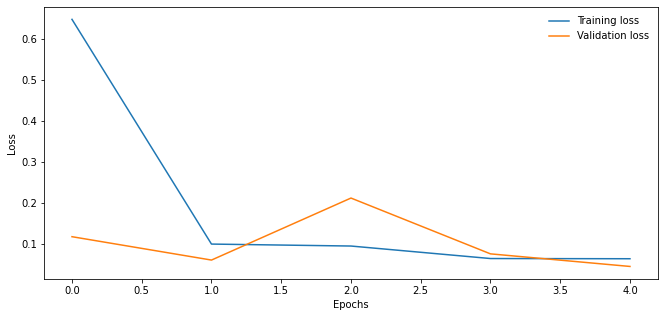

In [21]:
# графики

plt.figure(figsize=[11,5])
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

Даже простой полносвязной сетью получили точность на тесте 98 (получал 97-99) процентов для задачи бинарной классификации